In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1" #model will be trained on GPU 1

In [31]:
import numpy as np
import pandas as pd
from scipy.misc import derivative
import scipy.integrate as intg
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow.keras
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant, RandomNormal

from sklearn.metrics import mean_squared_error
from astroNN.nn.layers import MCDropout

## Se leen los archivos



In [41]:
# file = '/home/isidro/Documents/github/SNIa_ML_regressions/data/pantheon.txt'
file = 'https://raw.githubusercontent.com/igomezv/SNIa_ML_regressions/main/data/pantheon.txt'
syscov_file = 'https://raw.githubusercontent.com/igomezv/SNIa_ML_regressions/main/data/pantheon_errors.txt'
# file = 'data/lcparam_full_long.txt'
df = pd.read_csv(file, sep = " ", usecols=['zcmb', 'mb', 'dmb'])
# df = pd.read_csv(file, sep = " ")
dmag = df[['dmb']]
df = df[['zcmb', 'mb']]
N = len(df.values)
syscov = np.loadtxt(syscov_file, skiprows=1).reshape((N, N))
cov = np.copy(syscov)

In [42]:
df.head()

,zcmb,mb
0,0.50349,22.93445
1,0.49520,22.88020
2,0.67820,24.03770
3,0.86720,24.34685
4,0.79920,24.36050


In [43]:
dmag = dmag.values.reshape(N,)
np.shape(dmag)

(1048,)

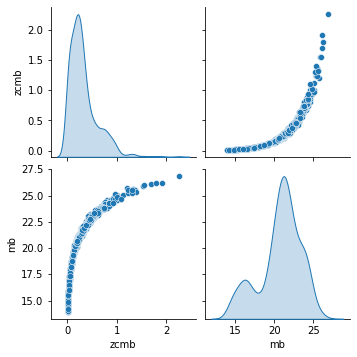

In [6]:
sns.pairplot(df, diag_kind="kde")

In [7]:
np.shape(dmag), np.shape(cov)
np.diag_indices_from(cov)

(array([   0,    1,    2, ..., 1045, 1046, 1047]),
 array([   0,    1,    2, ..., 1045, 1046, 1047]))

In [8]:
cov[np.diag_indices_from(cov)] += dmag**2

In [9]:
sq_errors = np.diag(syscov)
print(np.shape(sq_errors), type(sq_errors))

(1048,) <class 'numpy.ndarray'>


In [30]:
df['errors'] = np.sqrt(sq_errors+dmag**2)
df.head()

,zcmb,mb,errors
0,0.50349,22.93445,0.126758
1,0.49520,22.88020,0.118172
2,0.67820,24.03770,0.206020
3,0.86720,24.34685,0.174903
4,0.79920,24.36050,0.175347


In [11]:
# df['mb'] += 19.36

(0.0, 2.3)

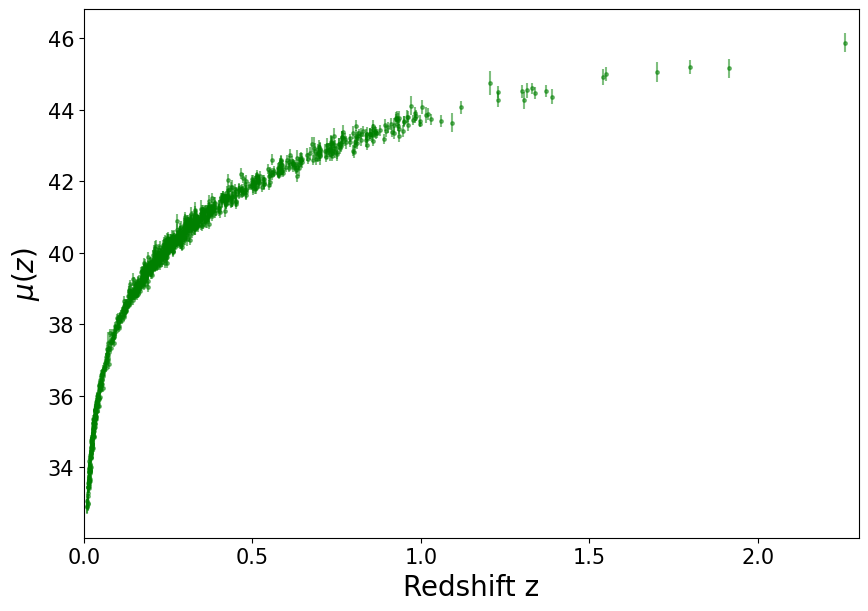

In [12]:
plt.figure(figsize=(10, 7), dpi=100)
plt.errorbar(df['zcmb'], df['mb']+19, df['errors'], fmt='g.', markersize=5, label='Observations', alpha=0.5)
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.xscale('log')


plt.ylabel("$\mu(z)$", fontsize=20)
plt.xlim(0, 2.3)

In [13]:
randomize = np.random.permutation(N)
data = df.values[randomize]

In [14]:
z = data[:,0]
y = data[:,1:]
# print(randomize)

In [15]:
scalerz = StandardScaler()
# scalerz = MinMaxScaler(feature_range=(-1,1))
# fit scaler on data
scalerz.fit(z.reshape(-1,1))
# apply transform
z = scalerz.transform(z.reshape(-1,1))

# scalery = MinMaxScaler(feature_range=(0,1))
# scalery = StandardScaler()
# scalery.fit(y)
# y = scalery.transform(y)

In [16]:
split = 0.8
ntrain = int(split * len(z))
indx = [ntrain]
z_train, z_test = np.split(z, indx)
y_train, y_test = np.split(y, indx)

In [17]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0.0,
                                   patience=50.0,
                                   restore_best_weights=True)]
#                      tf.keras.callbacks.ReduceLROnPlateau(patience=2)]

In [18]:
def RHSquared_a_owacdm(a, w0, wa, Om):
    rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
    return (Om/a**3+(1.0-Om)*rhow)

def DistIntegrand_a(a, w0, wa, Om):
        return 1./np.sqrt(RHSquared_a_owacdm(a, w0, wa, Om))/a**2
    
def Da_z(z, w0, wa, Om):
        r = intg.quad(DistIntegrand_a, 1./(1+z), 1, args=(w0, wa, Om))
        r = r[0]
        return r

### Hay que revisar esta constante en el return
def distance_modulus(z, w0=-1, wa=0.0, Om=0.23):
    return 5*np.log10(Da_z(z, w0, wa, Om)*(1+z))+24
# +43

zmodel = np.linspace(0.01, 2.4, 100)
flcdm = []
# fowacdm1 = []
# fowacdm2 = []
# fowacdm3 = []

om = 0.27
for zzz in zmodel:
    flcdm.append(distance_modulus(zzz, w0=-1, wa=0, Om=om))

#     fowacdm1.append(distance_modulus(zzz, w0=-1.3, wa=1.2))
#     fowacdm1.append(distance_modulus(zzz, w0=-1.09, wa=0.3, Om=om))
#     fowacdm2.append(distance_modulus(zzz, w0=-1.04, wa=-0.3, Om=om))
#     fowacdm3.append(distance_modulus(zz, model='owacdm', w0=-1, wa=0.0))
    
flcdm = np.array(flcdm)
# fowacdm1 = np.array(fowacdm1)
# fowacdm2 = np.array(fowacdm2)
# fowacdm3 = np.array(fowacdm3)

#### Ahora usando incertidumbres de la red con Monte Carlo Dropout

In [20]:
yy = y[:,0].reshape(-1,1)
zz = z
split = 0.8
ntrain = int(split * len(zz))
indx = [ntrain]
zz_train, zz_test = np.split(zz, indx)
yy_train, yy_test = np.split(yy, indx)
np.shape(zz_train), np.shape(yy_train), np.shape(zz_test), np.shape(yy_test)

((838, 1), (838, 1), (210, 1), (210, 1))

In [21]:
def model_regression_dropout(num_hidden):
    # Defeine Keras model for regression
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(batch_input_shape=((None, 1))))
    model.add(Dense(units=num_hidden[0], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.3))
    model.add(Dense(units=num_hidden[1], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.3))
    model.add(Dense(units=num_hidden[2], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.3))
    model.add(Dense(units=2, activation="linear"))
    return model

#Define some parameter
batch_size = 4
# optimizer = Adam(lr=.005)
optimizer = Adam(lr=0.0001)


# Compile Keras model
model = model_regression_dropout(num_hidden=[50, 200, 150])
model.summary()

Epoch 1/800
210/210 [==============================] - 1s 2ms/step - loss: 60.5303 - val_loss: 11.1014
Epoch 2/800
210/210 [==============================] - 0s 1ms/step - loss: 7.2665 - val_loss: 5.5108
Epoch 3/800
210/210 [==============================] - 0s 1ms/step - loss: 5.0803 - val_loss: 4.1120
Epoch 4/800
210/210 [==============================] - 0s 1ms/step - loss: 3.9530 - val_loss: 3.9554
Epoch 5/800
210/210 [==============================] - 0s 1ms/step - loss: 3.4925 - val_loss: 3.9603
Epoch 6/800
210/210 [==============================] - 0s 1ms/step - loss: 3.1561 - val_loss: 3.3900
Epoch 7/800
210/210 [==============================] - 0s 1ms/step - loss: 3.0377 - val_loss: 2.4024
Epoch 8/800
210/210 [==============================] - 0s 1ms/step - loss: 2.8489 - val_loss: 3.6696
Epoch 9/800
210/210 [==============================] - 0s 1ms/step - loss: 2.9377 - val_loss: 2.7136
Epoch 10/800
210/210 [==============================] - 0s 1ms/step - loss: 2.4955 - val_

Epoch 161/800
210/210 [==============================] - 0s 1ms/step - loss: 1.0008 - val_loss: 1.5118
Epoch 162/800
210/210 [==============================] - 0s 1ms/step - loss: 1.0496 - val_loss: 0.9876
Epoch 163/800
210/210 [==============================] - 0s 1ms/step - loss: 1.0071 - val_loss: 0.8868
Epoch 164/800
210/210 [==============================] - 0s 1ms/step - loss: 1.0415 - val_loss: 1.1081
Epoch 165/800
210/210 [==============================] - 0s 1ms/step - loss: 0.9760 - val_loss: 0.9745
Epoch 166/800
210/210 [==============================] - 0s 1ms/step - loss: 0.9602 - val_loss: 0.9818
Epoch 167/800
210/210 [==============================] - 0s 1ms/step - loss: 0.9967 - val_loss: 0.9727
Epoch 168/800
210/210 [==============================] - 0s 1ms/step - loss: 1.0640 - val_loss: 0.9483
Epoch 169/800
210/210 [==============================] - 0s 1ms/step - loss: 0.9827 - val_loss: 1.0105
Epoch 170/800
210/210 [==============================] - 0s 1ms/step - lo

210/210 [==============================] - 0s 1ms/step - loss: 0.6325 - val_loss: 0.5168
Epoch 320/800
210/210 [==============================] - 0s 1ms/step - loss: 0.6391 - val_loss: 0.5543
Epoch 321/800
210/210 [==============================] - 0s 1ms/step - loss: 0.6016 - val_loss: 0.5853
Epoch 322/800
210/210 [==============================] - 0s 1ms/step - loss: 0.5787 - val_loss: 0.6311
Epoch 323/800
210/210 [==============================] - 0s 1ms/step - loss: 0.5678 - val_loss: 0.5153
Epoch 324/800
210/210 [==============================] - 0s 1ms/step - loss: 0.6177 - val_loss: 0.5934
Epoch 325/800
210/210 [==============================] - 0s 1ms/step - loss: 0.4936 - val_loss: 0.5116
Epoch 326/800
210/210 [==============================] - 0s 1ms/step - loss: 0.5556 - val_loss: 0.6939
Epoch 327/800
210/210 [==============================] - 0s 1ms/step - loss: 0.6326 - val_loss: 0.6601
Epoch 328/800
210/210 [==============================] - 0s 1ms/step - loss: 0.5588 - v

210/210 [==============================] - 0s 1ms/step - loss: 0.3483 - val_loss: 0.2875
Epoch 478/800
210/210 [==============================] - 0s 1ms/step - loss: 0.3282 - val_loss: 0.3584
Epoch 479/800
210/210 [==============================] - 0s 1ms/step - loss: 0.3105 - val_loss: 0.3443
Epoch 480/800
210/210 [==============================] - 0s 1ms/step - loss: 0.3106 - val_loss: 0.3376
Epoch 481/800
210/210 [==============================] - 0s 1ms/step - loss: 0.2980 - val_loss: 0.3687
Epoch 482/800
210/210 [==============================] - 0s 1ms/step - loss: 0.3358 - val_loss: 0.3810
Epoch 483/800
210/210 [==============================] - 0s 1ms/step - loss: 0.3530 - val_loss: 0.2206
Epoch 484/800
210/210 [==============================] - 0s 1ms/step - loss: 0.3468 - val_loss: 0.3155
Epoch 485/800
210/210 [==============================] - 0s 1ms/step - loss: 0.3241 - val_loss: 0.3217
Epoch 486/800
210/210 [==============================] - 0s 1ms/step - loss: 0.3508 - v

210/210 [==============================] - 0s 1ms/step - loss: 0.1897 - val_loss: 0.1842
Epoch 636/800
210/210 [==============================] - 0s 1ms/step - loss: 0.1909 - val_loss: 0.1611
Epoch 637/800
210/210 [==============================] - 0s 1ms/step - loss: 0.1780 - val_loss: 0.1639
Epoch 638/800
210/210 [==============================] - 0s 1ms/step - loss: 0.1613 - val_loss: 0.1590
Epoch 639/800
210/210 [==============================] - 0s 1ms/step - loss: 0.1758 - val_loss: 0.1667
Epoch 640/800
210/210 [==============================] - 0s 1ms/step - loss: 0.1692 - val_loss: 0.1736
Epoch 641/800
210/210 [==============================] - 0s 1ms/step - loss: 0.1739 - val_loss: 0.1621
Epoch 642/800
210/210 [==============================] - 0s 1ms/step - loss: 0.2040 - val_loss: 0.1600
Epoch 643/800
210/210 [==============================] - 0s 1ms/step - loss: 0.1696 - val_loss: 0.2752
Epoch 644/800
210/210 [==============================] - 0s 1ms/step - loss: 0.1741 - v

210/210 [==============================] - 0s 1ms/step - loss: 0.1381 - val_loss: 0.1250
Epoch 794/800
210/210 [==============================] - 0s 1ms/step - loss: 0.1154 - val_loss: 0.1150
Epoch 795/800
210/210 [==============================] - 0s 1ms/step - loss: 0.1329 - val_loss: 0.1048
Epoch 796/800
210/210 [==============================] - 0s 1ms/step - loss: 0.1180 - val_loss: 0.1338
Epoch 797/800
210/210 [==============================] - 0s 1ms/step - loss: 0.1231 - val_loss: 0.1054
Epoch 798/800
210/210 [==============================] - 0s 1ms/step - loss: 0.1162 - val_loss: 0.1046
Epoch 799/800
210/210 [==============================] - 0s 1ms/step - loss: 0.1115 - val_loss: 0.0986
Epoch 800/800
210/210 [==============================] - 0s 1ms/step - loss: 0.1230 - val_loss: 0.1114


In [ ]:
model.compile(loss='mse', optimizer=optimizer) 
# model2_train = model.fit(zz_train, yy_train, 
# #                          validation_split=0.0, 
#                          batch_size=batch_size, epochs=1000, verbose=1,
#                          validation_data=(zz_test, yy_test))    
model2_train = model.fit(z_train, y_train, batch_size=batch_size,
                                    epochs=800,verbose=1,
                                    validation_data=(z_test, y_test))

In [44]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 50)                100       
                                                                 
 MCDropout_1 (MCDropout)     (None, 50)                0         
                                                                 
 dense_5 (Dense)             (None, 200)               10200     
                                                                 
 MCDropout_2 (MCDropout)     (None, 200)               0         
                                                                 
 dense_6 (Dense)             (None, 150)               30150     
                                                                 
 MCDropout_3 (MCDropout)     (None, 150)               0         
                                                                 
 dense_7 (Dense)             (None, 2)                 3

In [37]:
model2_train.history['val_loss'][-1]

0.11140689253807068

In [22]:
# Generate test data
test_batch_size = 1000
# x_test = np.random.uniform(0, 2., test_batch_size)
x_test = np.linspace(0, 2., test_batch_size)

mc_dropout_num = 100  # Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 2))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))
for i in range(mc_dropout_num):
    predictions[i] = model.predict(scalerz.transform(x_test.reshape(-1,1)))
    
# get mean results and its varience
prediction_mc_dropout = np.mean(predictions, axis=0)
std_mc_dropout = np.std(predictions, axis=0)

32/32 [==============================] - 0s 782us/step


In [23]:
np.mean(std_mc_dropout[:,0]), np.mean(std_mc_dropout[:,1])

(0.6511744401960006, 0.026556298357455536)

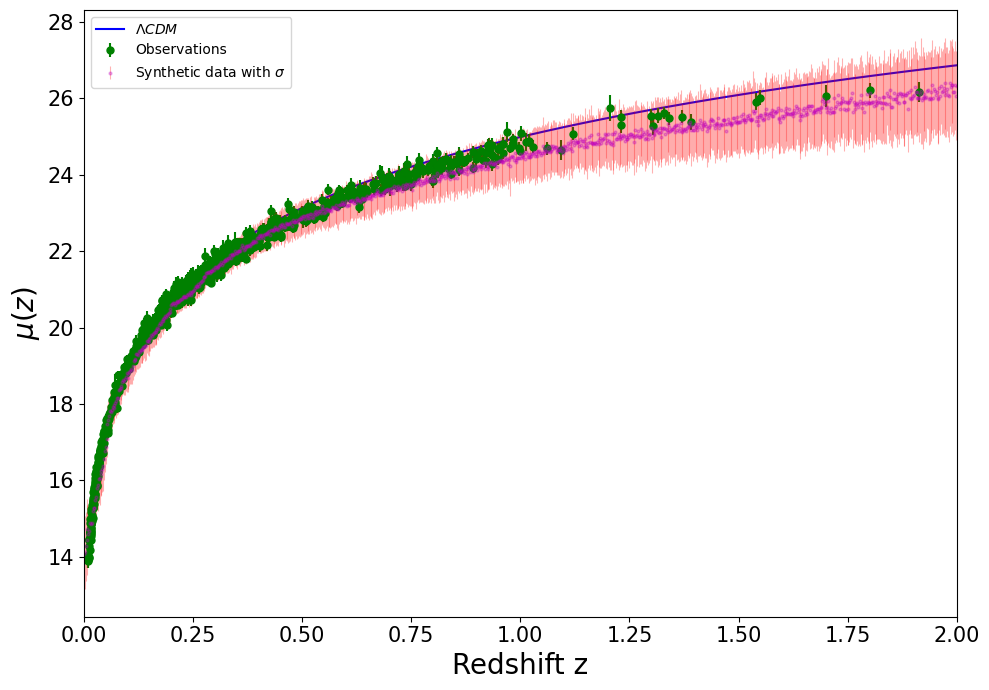

In [24]:
# Plotting
plt.figure(figsize=(10, 7), dpi=100)
# plt.figure(figsize=(5, 4), dpi=100)
sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2)


# plt.scatter(scalerz.inverse_transform(zz), yy, color='k', label='Original cosmic chronometers')
plt.plot(zmodel, flcdm, label='$\Lambda CDM$', c='b')
plt.errorbar(df['zcmb'], df['mb'], df['errors'], fmt='g.', markersize=10, label='Observations')
plt.errorbar(x_test, prediction_mc_dropout[:,0], yerr=sigma, markersize=2, fmt='o', 
             ecolor='r', capthick=2, elinewidth=0.8, alpha=0.3, c='m',
             label='Synthetic data with $\sigma$')

plt.xlim(0,2)

# plt.xlabel('Redshift')
# plt.ylabel('$H(z)$')
plt.ylabel("$\mu(z)$", fontsize=20)
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.legend(loc='best')
plt.legend(loc='upper left')
# plt.show()
plt.tight_layout()


In [25]:
 prediction_mc_dropout[0,:]

array([14.06518741,  0.17220312])

([], [])

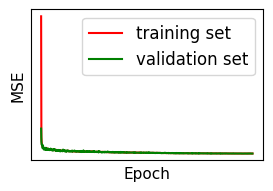

In [26]:
plt.figure(figsize=(3, 2), dpi=100)

plt.plot(model2_train.history['loss'], color='r', )
plt.plot(model2_train.history['val_loss'], color='g')

plt.ylabel('MSE', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=12)
plt.xticks(fontsize=10)
plt.xticks([])
plt.yticks([])


In [27]:
# model.save('FFNN+MC-DO_Hz.h5')
# tf.keras.models.save_model(neural_model2, '../models/FFNN_MC_DO.h5' )

In [28]:
mookdp = np.concatenate((x_test.reshape(-1,1), prediction_mc_dropout), axis=1)

# np.savetxt("data.dat",mookdp, delimiter=" ")

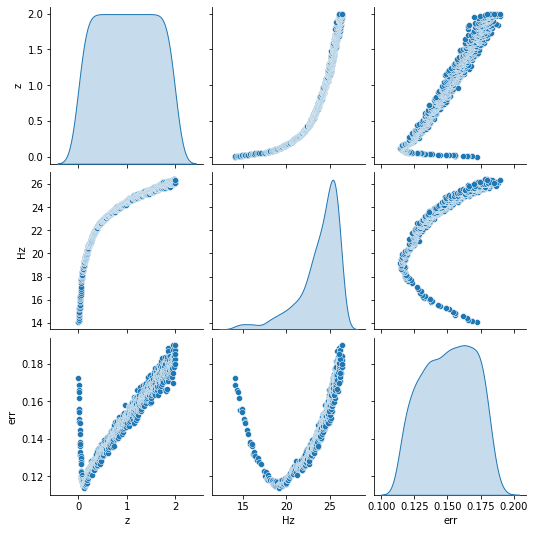

In [29]:
dfMook = pd.DataFrame(mookdp, columns=['z', 'Hz', 'err'])
sns.pairplot(dfMook, diag_kind="kde")
# plt.savefig("50hdmookdropout.png")